In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import os
from utils import tools
from sklearn import preprocessing
from torchviz import make_dot, make_dot_from_trace


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

from utils.frame_utils import read_gen
import argparse

In [2]:
from models import *
import matplotlib.pyplot as plt

In [3]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [4]:
ret, frame1 = cap.read()

In [5]:
frame1.shape

(576, 768, 3)

In [6]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    # Take at 5Hz frequency which is framerate/5
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 162:610 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## BUilding Dataset

In [3]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        # normalization for lstm data
        self.train_scaler = preprocessing.StandardScaler()
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        
        # normalization
        array_input_scaled = self.train_scaler.fit_transform(array_input)
        
        input_lstm  = Variable(torch.from_numpy(array_input_scaled).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,448)
            x_data_np_2 = x_data_np_2.reshape(3,512,448)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x).transpose( 0, 2, 1, 3,4)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y.mean(1)

In [4]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 448]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [5]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 448]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [6]:
lstm_data = dataset.get_input_lstm()
# Though there are 4000, we will only call first 3400, constrained by the length of 'num_train_img'
lstm_data.shape

(4000, 20, 11)

In [7]:
def plot_feature_dim(lstm_input):
    fig, axs = plt.subplots(4,3,figsize=(15,15))

    for i in range(4):
        for j in range(3):
            if (i == 3 and j == 2):
                break

            x = np.arange(0,80000)
            axs[i,j].plot(x,lstm_input[:,i*3+j])
            axs[i,j].set_title(f'Feature {i*3+j+1}')

### LSTM input data is all normalized in 11-channels

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(80000, 11)

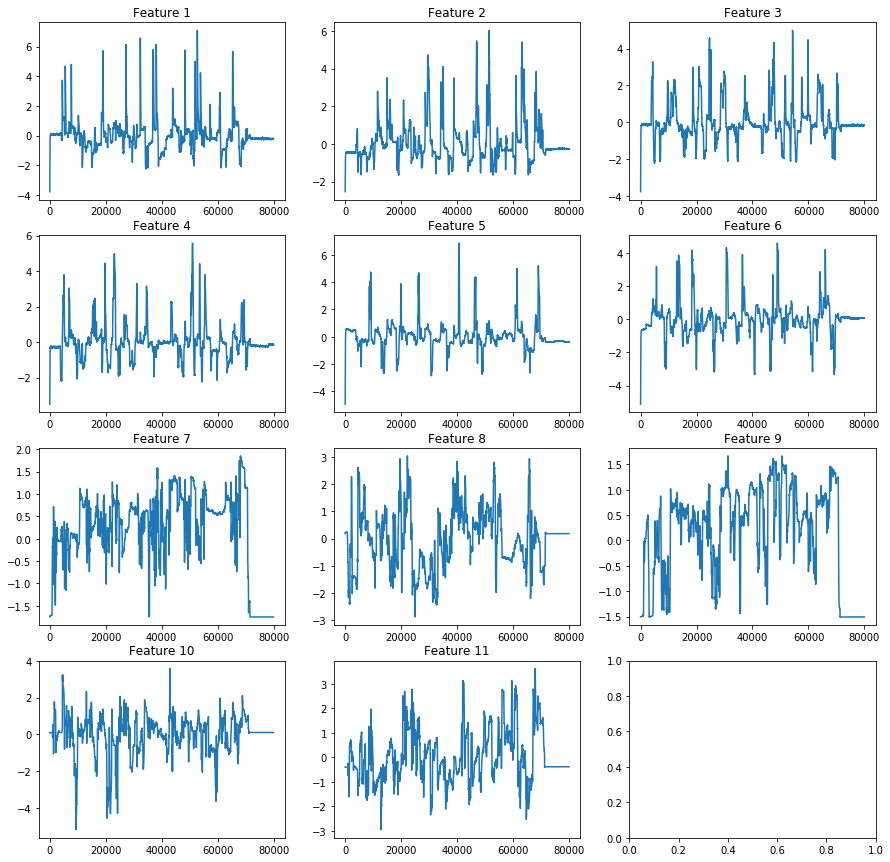

In [8]:
lstm_input = dataset.read_OMEGA7_LC()
lstm_input = lstm_input.reshape(4000*20, -1)
plot_feature_dim(lstm_input)
lstm_input.shape

In [11]:
class argparse():
    def __init__(self):
        super(argparse, self).__init__()
        self.rgb_max = 255.
        self.fp16 = False
        self.inference_size = [1080, 1920]
        self.crop_size = [384, 512]
        self.effective_batch_size = 1
args = argparse()

# Create Our model & Sanity check

In [13]:
model = Surgical_VINet()

pre_trained_weights found
....creating model....
....loading weights....


In [14]:
for param in model.flownet_c.parameters():
    param.requires_grad = False

In [15]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 448]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [16]:
batch_size, timesteps, C, H, W = X.size()
        
## Input1: Feed image pairs to FlownetC
c_in = X.view(batch_size, timesteps * C, H, W)
c_out = model.flownet_c(c_in)

In [17]:
def model_out_to_flow_png(output):
    out_np = output[0].data.cpu().numpy()

    #https://gitorchub.com/DediGadot/PatchBatch/blob/master/flowlib.py
    out_np = np.squeeze(out_np)
    out_np = np.moveaxis(out_np,0, -1)

    im_arr = flowlib.flow_to_image(out_np)
    im = Image.fromarray(im_arr)
    im.save('test.png')

In [18]:
c_out.size()

torch.Size([1, 2, 8, 7])

In [19]:
import flowlib
model_out_to_flow_png(c_out)

max flow: 10362.5020
flow range:
u = -10337.443 .. 2694.933
v = -3950.605 .. 3680.861


In [20]:
output = model(X,X2)
(output.size(), Y.size())

(torch.Size([1, 3]), torch.Size([1, 3]))

In [21]:
criterion = nn.MSELoss()

loss = criterion(output, Y)
loss

tensor(0.8266, device='cuda:0', grad_fn=<MseLossBackward>)

In [22]:
criterion = nn.L1Loss(size_average=False)

loss = criterion(output, Y)
loss

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(1.9345, device='cuda:0', grad_fn=<L1LossBackward>)

# Visulization of network

In [23]:
image = X
imu   = X2
y = model(image, imu)
dot = make_dot(y, params = dict(list(model.named_parameters()) + [('x',X), ('x2',X2)]))

In [24]:
dot.save(filename='My_new_Network')

'My_new_Network'

In [25]:
dot.render()

'My_new_Network.pdf'

In [26]:
def train():
    # hyper-parameters
    epoch = 2
    batch = 1
    lr = 0.001
    
    # creat model and dataset
    model = Surgical_VINet()
    mydataset = MyDataset()
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
#     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # TensorBoard
    writer = SummaryWriter()
 
    model.train()
    
    mydataset = MyDataset()
    
#     criterion = nn.MSELoss()
    criterion  = nn.L1Loss(size_average=False)
    
    start = 5
    end = len(mydataset) - batch
    batch_num = (end - start)
    startT = time.time()
    
    with tools.TimerBlock("Start training") as block :
        for k in range(epoch):
            for i in range(start, end):
                data, data_lstm, target = mydataset.load_img_bat(i, batch)
#                 data, data_lstm, target = data.cuda(), data_lstm.cuda(), target.cuda()
                
                optimizer.zero_grad()
                
                # forward pass
                output = model(data, data_lstm)
                
                # compute loss
                loss = criterion(output, target)
                
                # backward pass
                loss.backward()
#                 torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                optimizer.step()
                
                avgTime = block.avg()
                remainingTime = int((batch_num*epoch -  (i + batch_num*k)) * avgTime)
                rTime_str = "{:02d}:{:02d}:{:02d}".format(int(remainingTime/60//60), 
                                                          int(remainingTime//60%60), 
                                                          int(remainingTime%60))
                block.log(f'Train Epoch: {k}\t[{i}/{batch_num} ({(100.*(i + batch_num*k)):.0f}%)]\tLoss: {loss.data:.6f}, TimeAvg: {avgTime:.4f}, Remaining: {rTime_str}')
                          
                writer.add_scalar('loss', loss.data, k*batch_num + i)
                

                
                
                
            check_str = 'checkpoint_{}.pt'.format(k)
            if (k+1)%5 == 0:
                torch.save(model.state_dict(), check_str)
    
    torch.save(model.state_dict(), 'test_network_trial_1.pt')
    writer.export_scalars_to_json("./summary_writer.json")
    writer.close()

In [27]:
train()

pre_trained_weights found
....creating model....
....loading weights....


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Start training
  [0.797s] Train Epoch: 0	[5/3394 (500%)]	Loss: 2.058017, TimeAvg: 0.5627, Remaining: 01:03:36
  [1.571s] Train Epoch: 0	[6/3394 (600%)]	Loss: 2.034557, TimeAvg: 0.9577, Remaining: 01:48:14
  [2.405s] Train Epoch: 0	[7/3394 (700%)]	Loss: 1.930780, TimeAvg: 0.8769, Remaining: 01:39:06
  [3.243s] Train Epoch: 0	[8/3394 (800%)]	Loss: 1.777912, TimeAvg: 0.8563, Remaining: 01:36:45
  [3.997s] Train Epoch: 0	[9/3394 (900%)]	Loss: 1.592805, TimeAvg: 0.8491, Remaining: 01:35:56
  [4.780s] Train Epoch: 0	[10/3394 (1000%)]	Loss: 1.498883, TimeAvg: 0.8325, Remaining: 01:34:02
  [5.550s] Train Epoch: 0	[11/3394 (1100%)]	Loss: 1.358509, TimeAvg: 0.8235, Remaining: 01:33:00
  [6.333s] Train Epoch: 0	[12/3394 (1200%)]	Loss: 1.163840, TimeAvg: 0.8194, Remaining: 01:32:32
  [7.110s] Train Epoch: 0	[13/3394 (1300%)]	Loss: 1.162808, TimeAvg: 0.8129, Remaining: 01:31:47
  [7.884s] Train Epoch: 0	[14/3394 (1400%)]	Loss: 1.077531, TimeAvg: 0.8096, Remaining: 01:31:24
  [8.656s] Train Epoch: 0

KeyboardInterrupt: 